# VASCA result analysis example TDS
### Example notebook to have a look at the results of 'vasca_pipe -cfg ../vasca_cfg.yaml' from the examples folder. The output of the pipline was stored in the folder vasca_pipeline.

In [28]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from jdaviz import Imviz
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits

from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

region_name = "TDS"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"

### Basic region information

In [29]:
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)
sel_srcs = rg.tt_sources["sel"]
display(rg.tt_sources[sel_srcs])
#rg.info() # Show available tables

field_id,name,ra,dec,observatory,obs_filter,sel,fov_diam,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,,deg,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes22,bool,float32,int32,float32,float64,float64,int32
GNU2592597978464124928,PS_XMMLSS_MOS00,35.578863351058885,-3.14176421214975,GALEX,NUV,True,1.1,27,40457.25,54791.262777777774,57213.3405928096,0
GNU2592668347208302592,PS_XMMLSS_MOS01,36.49984981667359,-3.4923125504146,GALEX,NUV,True,1.1,26,38608.996,54791.33122685185,57205.55893265336,1
GNU2592738715952480256,PS_XMMLSS_MOS02,34.995648096666685,-3.95320684099725,GALEX,NUV,True,1.1,24,23118.55,54791.399976851855,56670.07746654369,2
GNU2592809084696657920,PS_XMMLSS_MOS03,35.87152971805409,-4.25258328683038,GALEX,NUV,True,1.1,21,31699.102,54791.468136574076,57205.5459979022,3
GNU2592879453440835584,PS_XMMLSS_MOS04,36.890941423843685,-4.42319486511272,GALEX,NUV,True,1.1,23,34784.05,54791.53658564815,57214.614389105904,4
GNU2592949822185013248,PS_XMMLSS_MOS05,35.19163328261652,-5.0517494636978,GALEX,NUV,True,1.1,22,32845.8,54791.60503472222,57205.68289605035,5
...,...,...,...,...,...,...,...,...,...,...,...,...
GNU2607093939764723712,PS_GROTH_MOS02,213.77799348532596,54.3533934809404,GALEX,NUV,True,1.1,17,24084.25,54955.519328703704,57231.765437282986,36


fd_src_id,ra,dec,pos_err_mean,pos_err,pos_var,nr_det,nr_uls,mag_mean,mag_err_mean,mag_var,flux_cpval,flux_rchiq,mag_dmax,mag_dmax_abs,mag_dmax_sig,ul_weight,mag_sig_int2,mag_skew,sel,rg_fd_id,rg_src_id,nr_fd_srcs
,deg,deg,deg,deg,deg,,,mag,mag,mag2,,,mag,mag,,,mag,,,,,
int32,float64,float64,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32
-1,334.721147235789,0.3913897432978659,0.00018681558,2.9837034e-05,5.8081433e-08,39,0,20.045197,0.04776772,0.0068195807,1.350766e-09,3.0129654,0.23922157,0.23922157,4.3842154,-1.0,0.0045378255,0.7637885,True,-1,64,2
-1,334.60402277431285,0.407370591921308,0.00015331786,2.1656691e-05,1.6772194e-08,50,0,19.28677,0.02643091,0.001997267,1.4701795e-10,2.838165,0.095056534,0.095056534,3.6116586,-1.0,0.0012986739,-0.40703997,True,-1,152,2
-1,334.3717267899661,0.14254577202050692,0.00015080986,1.8526962e-05,3.770783e-08,66,0,18.495457,0.016990429,0.001065137,1.0106323e-21,3.6768827,0.08370781,0.08370781,5.7375617,-1.0,0.0007764623,0.76298386,True,-1,367,2
-1,334.33170174345287,-0.533245063599903,0.00021216141,3.5940262e-05,4.4736726e-08,34,0,22.02336,0.1698533,0.092994355,1.5209282e-07,2.802333,0.45415688,0.8100014,4.1725416,-1.0,0.06414421,0.95011145,True,-1,407,2
-1,334.2240175997951,1.08604823764695,0.00014684712,2.7715962e-05,6.87283e-08,28,0,17.871618,0.012457112,0.0008277288,1.0021767e-17,5.291074,0.05558014,0.062379837,4.8380957,-1.0,0.0006725492,-0.23379636,True,-1,497,2
-1,334.16724395647196,0.2722786950215215,0.0001776194,4.0678453e-05,2.2336675e-08,19,0,20.13708,0.04590725,0.011777934,6.6969965e-13,5.409479,0.22940826,0.22940826,5.4233027,-1.0,0.009670458,-0.4819989,True,-1,540,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,34.66462851392992,-4.262251248779774,0.00013444296,4.2497908e-05,2.3427013e-08,10,0,17.687214,0.011521755,0.0010465445,2.5800252e-12,8.213447,0.04071617,0.05684471,4.0599074,-1.0,0.0009137937,-0.29538462,True,-1,222642,1


### Basic info source TDE PS1-10jh

Found VASCA source is at distance: 0.0002552198797977209 deg


field_id,name,ra,dec,observatory,obs_filter,sel,fov_diam,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id,fd_src_id
,,deg,deg,,,,deg,,s,d,d,,
bytes22,bytes22,float64,float64,bytes22,bytes22,bool,float32,int32,float32,float64,float64,int32,int32[1]
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,True,1.1,22,28044.65,54960.52040509259,56810.67461805556,19,1581


fd_src_id,ra,dec,pos_err_mean,pos_err,pos_var,nr_det,nr_uls,mag_mean,mag_err_mean,mag_var,flux_cpval,flux_rchiq,mag_dmax,mag_dmax_abs,mag_dmax_sig,ul_weight,mag_sig_int2,mag_skew,sel,rg_fd_id,rg_src_id,nr_fd_srcs
,deg,deg,deg,deg,deg,,,mag,mag,mag2,,,mag,mag,,,mag,,,,,
int32,float64,float64,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32
-1,242.36798811674439,53.67344982477235,0.0001884135,5.7391357e-05,8.7359126e-08,10,0,21.619566,0.14499016,1.4587989,0.0,358.11386,2.359789,2.359789,91.9412,-1.0,1.4377767,-1.4794545,True,-1,57124,1


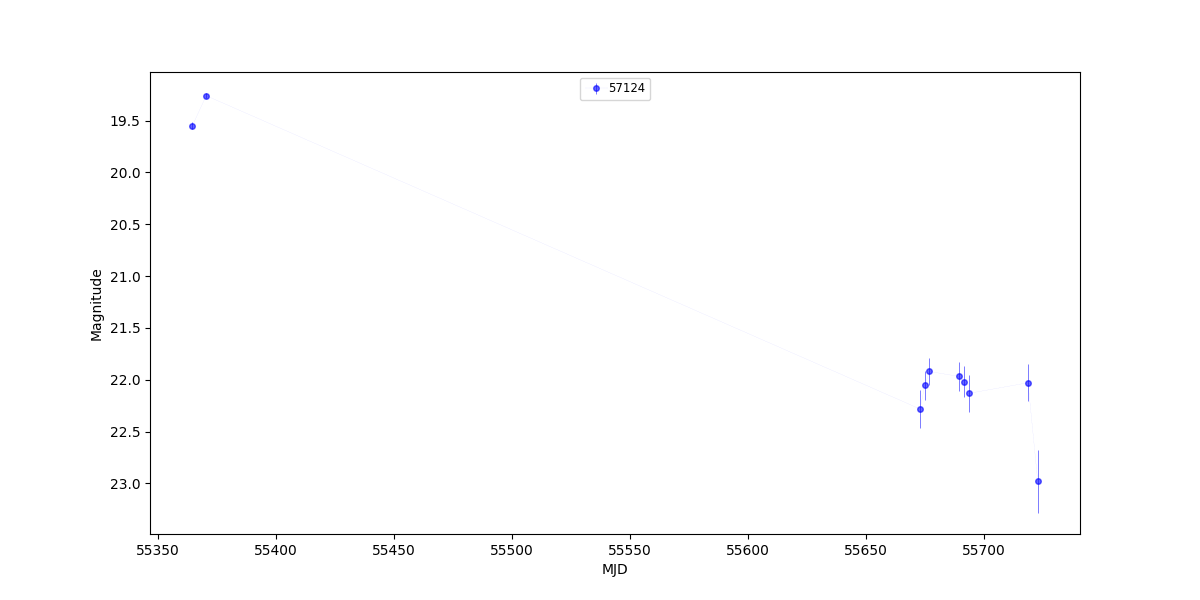

In [30]:
# αJ2000 = 16h09min28.296s, δJ2000 = +53 deg 40′ 23.52′′ from arXiv:1205.0252 in field "GNU2597664528044916736"
#logger.enable("vasca")

src_ps1tde, dist = rg.get_src_from_sky_pos('16h09m28.296s', '+53d40m23.52s')
print("Found VASCA source is at distance:",dist.degree,"deg")

fig_lc = plt.figure(figsize=(12, 6))
vvis.plot_light_curve(src_ps1tde,rg_src_ids=src_ps1tde.tt_sources["rg_src_id"][0])
display(src_ps1tde.tt_fields)
display(src_ps1tde.tt_sources)

### Display TDE PS1-10jh field in the sky

idx,fd_src_id,ra,dec,pos_err_mean,pos_err,pos_var,nr_det,nr_uls,mag_mean,mag_err_mean,mag_var,flux_cpval,flux_rchiq,mag_dmax,mag_dmax_abs,mag_dmax_sig,ul_weight,mag_sig_int2,mag_skew,sel
,,deg,deg,deg,deg,deg,,,mag,mag,mag2,,,mag,mag,,,mag,,
0,1581,242.36798811674439,53.67344982477235,0.00018841348,5.7391357e-05,8.7359126e-08,10,0,21.619566,0.14499018,1.4587986,0.0,358.1139,2.359789,2.359789,91.9412,-1.0,1.4377764,-1.4794545,True


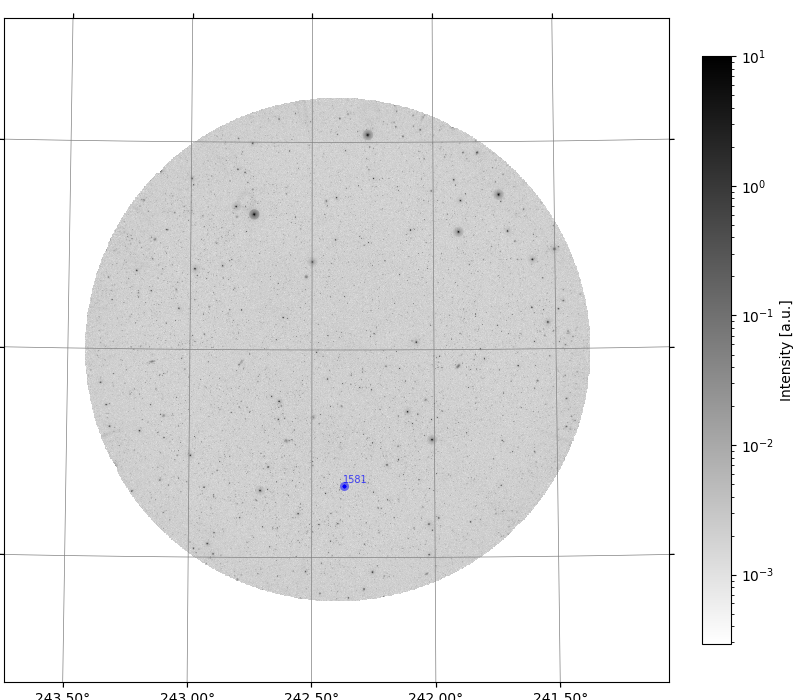

In [31]:
fd = rg.fields[src_ps1tde.tt_fields[0]["field_id"]]
fd_src_id = src_ps1tde.tt_fields["fd_src_id"][0]
fd.tt_sources.add_index("fd_src_id")
src_idx = fd.tt_sources.loc_indices["fd_src_id",fd_src_id ]
sel_src = np.zeros(len(fd.tt_sources),dtype=bool)
sel_src[src_idx]=True
fd.tt_sources["sel"][:]=sel_src

fig_sky = vvis.plot_field_sky(fd,plot_detections=True)

Table(fd.tt_sources[src_idx]).show_in_notebook()

### Show TDS coverage maps

<HpxGnomonicAxes: title={'center': 'Nr. of visits'}>

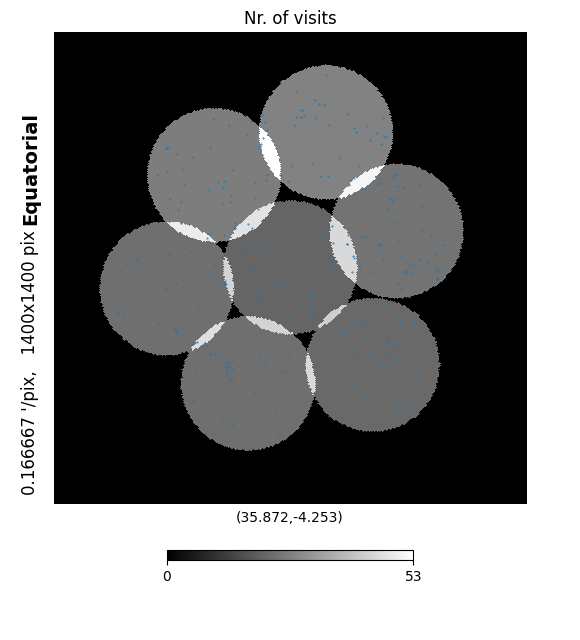

In [32]:
#logger.enable("vasca")
plot_coverage = False
if plot_coverage:
    rg.add_coverage_hp(nside=4096)
    vvis.plot_region_sky_mollview(rg, var="nr_vis")
    vvis.plot_region_sky_mollview(rg, var="nr_fds")
    vvis.plot_region_sky_mollview(rg, var="exp")
rg.add_coverage_hp(nside=4096, coord_sys="icrs")
vvis.plot_region_sky_gnomeview(rg,rg.tt_fields[3]["ra"],rg.tt_fields[3]["dec"])

### Sky image with Imviz, show source and detection markers on-top

In [33]:
show_imviz = False
if show_imviz:
    hdup = fits.PrimaryHDU(fd.ref_img, header=fd.ref_wcs.to_header())
    imviz = Imviz()
    viewer = imviz.default_viewer
    imviz.load_data(hdup, data_label=str(field_id))
    imviz.show(loc='sidecar')

    sel_det = fd.tt_detections["sel"]
    tt_det_sky = Table({'coord': SkyCoord(fd.tt_detections[sel_det]["ra"], fd.tt_detections[sel_det]["dec"], frame='fk5')})
    viewer.marker = {'color':'blue', 'markersize': 5., 'fill': False} #, 'alpha': 1.0
    viewer.add_markers(tt_det_sky, use_skycoord=True, marker_name='D')

    srcs_sky = SkyCoord(fd.tt_sources["ra"], fd.tt_sources["dec"], frame='fk5')
    tt_srcs_sky = Table({'coord':srcs_sky })
    viewer.marker = {'color':'red', 'markersize': 2., 'fill': True} #, 'alpha': 1.0
    viewer.add_markers(tt_srcs_sky, use_skycoord=True, marker_name='S')

### Show TDS diagnostic plots
#### Display distribution for all sources in the region

Total / selected sources: 1933 / 149140 ( 1.3 %)


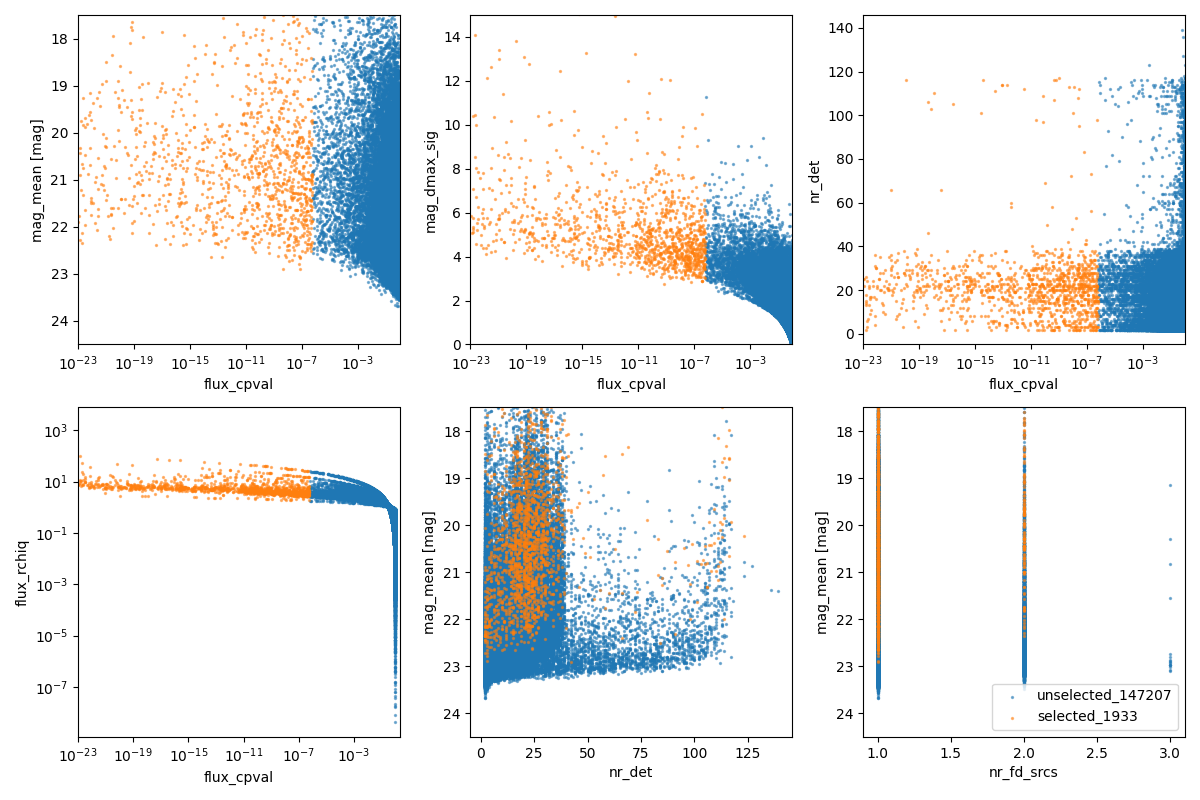

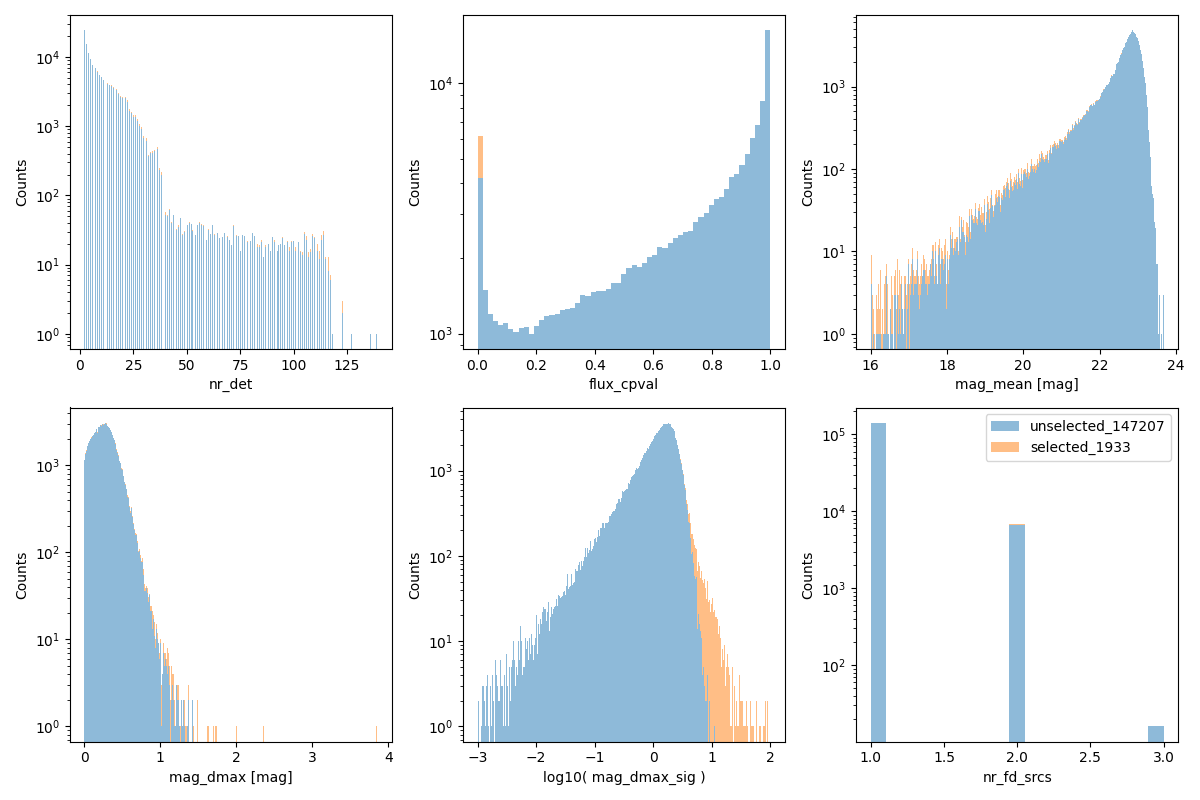

In [34]:
fig_fd_det_diag_scat = vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")
fig_rg_src_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")
sel= rg.tt_sources["sel"]
nr_sel_srcs =len(rg.tt_sources[sel])
nr_srcs = len(rg.tt_sources)
print("Total / selected sources:",nr_sel_srcs,"/",nr_srcs,"(",np.round(100*nr_sel_srcs/nr_srcs,2),"%)")

#### Display distribution for all detections in the field of TDE PS1-10jh

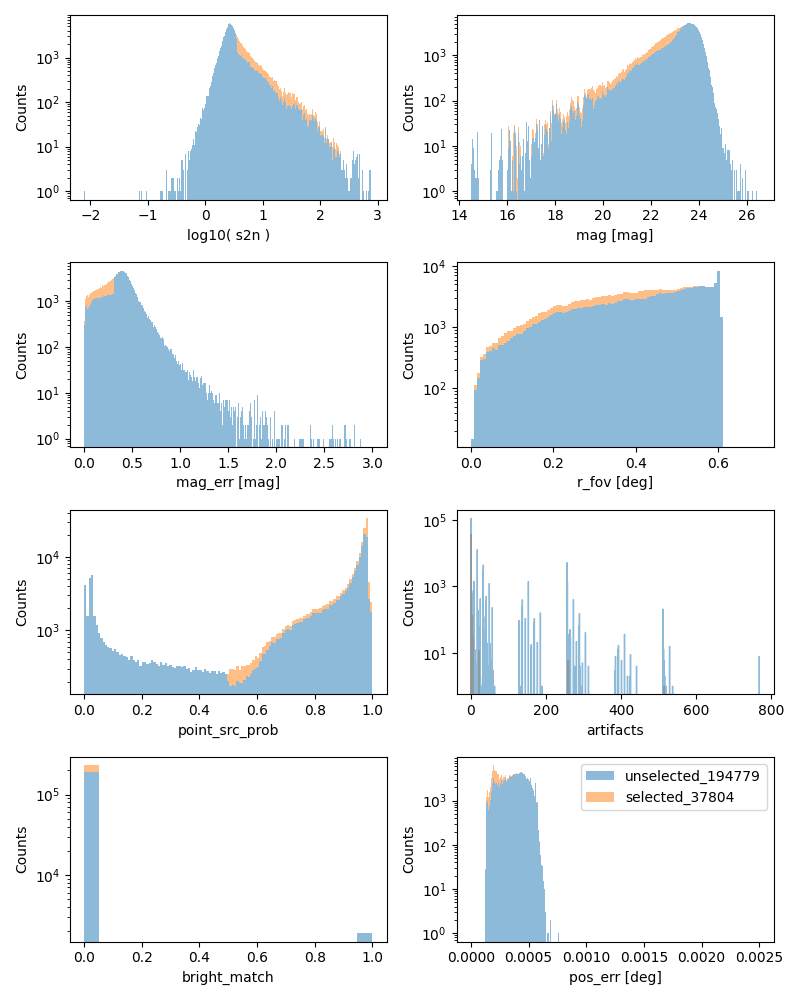

In [35]:
fig_det_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(fd, "tt_detections", "hist",fig_size=(8, 10))

### Look into more details for the chisquare distribution

Text(0.5, 0, 'Reduced chisquare')

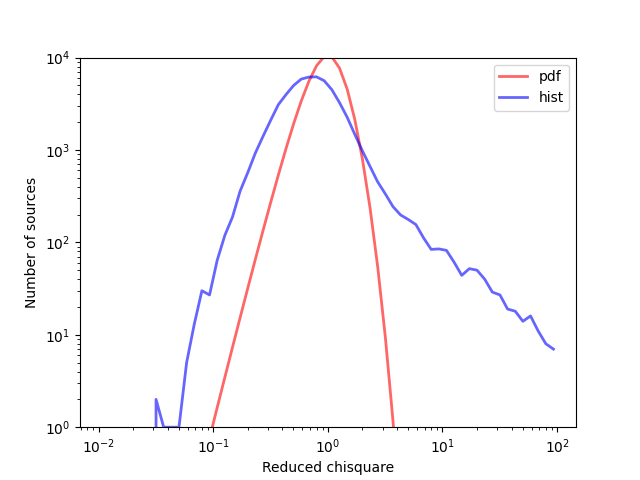

In [36]:
#Setup binning
rchisq_bins_lg = np.linspace(-2, 2, 61)
rchisq_bins = np.power(10,rchisq_bins_lg)
rchisq_bins_mean = (rchisq_bins[:-1]+rchisq_bins[1:])/2.
rchisq_bins_width = rchisq_bins[1:]-rchisq_bins[:-1]

#Select events
sel_det = rg.tt_sources["nr_det"]>10

#Calculate expected rchiq distribution for selected events
rchsq_pdf = np.zeros(len(rchisq_bins_mean))
#Get summed reduced chisquare distribution
for src in rg.tt_sources[sel_det]:
    rchsq_pdf += chi2.pdf(rchisq_bins_mean, src["nr_det"]-1, scale = 1/(src["nr_det"]-1) )*rchisq_bins_width 

rchiq_hist, bins = np.histogram(rg.tt_sources[sel_det]["flux_rchiq"], bins = rchisq_bins)

fig_rchsq = plt.figure()
plt.loglog(rchisq_bins_mean, rchsq_pdf ,'r-', lw=2, alpha=0.6, label='pdf')
plt.loglog(rchisq_bins_mean, rchiq_hist ,'b-', lw=2, alpha=0.6, label='hist')
plt.ylim(1e-0,1e4)
plt.legend()
plt.ylabel("Number of sources")
plt.xlabel("Reduced chisquare")

### Look at the Pval distibutions for different magnitudes

[]

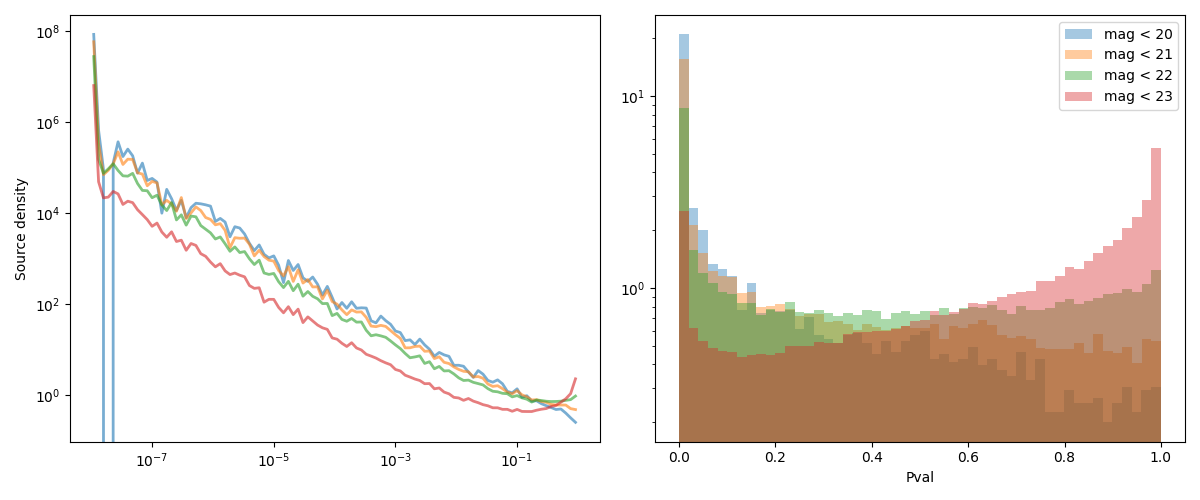

In [37]:
#Get pval data and saturate it at low Pval for better plotting
pval_min = 1e-8
pvals = rg.tt_sources["flux_cpval"]
pvals = (pvals<pval_min+1e-12)*(pval_min+1e-12)+(pvals>pval_min)*pvals

#if plot_logx:
pval_bins_lg = np.linspace(np.log10(pval_min), 0, 101)
pval_bins = np.power(10,pval_bins_lg)
pval_bins_mean = (pval_bins[:-1]+pval_bins[1:])/2.

#Plotting for different magnitude cuts
fig_pval, axs = plt.subplots(1, 2, figsize=(12, 5), squeeze=False)
axs = axs.flatten()
for mag_cut in range(20,24):
    sel_mag = (rg.tt_sources["mag_mean"]<mag_cut) #* (rg.tt_sources["mag_mean"]>mag_cut-1)

    pval_hist, bins = np.histogram(pvals[sel_mag], bins=pval_bins, density=True)
    axs[0].loglog(pval_bins_mean, pval_hist , lw=2, alpha=0.6, label=str(mag_cut))
    axs[1].hist(rg.tt_sources[sel_mag]["flux_cpval"], bins=50, density=True ,label="mag < "+str(mag_cut),alpha=0.4)   #, ,cumulative=1


axs[0].set_ylabel("Source density")
axs[1].set_xlabel("Pval")
axs[1].set_xlabel("Pval")
plt.legend()
plt.tight_layout()
plt.semilogy()

### Reproduce Fig. 3 from Gezari et al. ApJ 2013

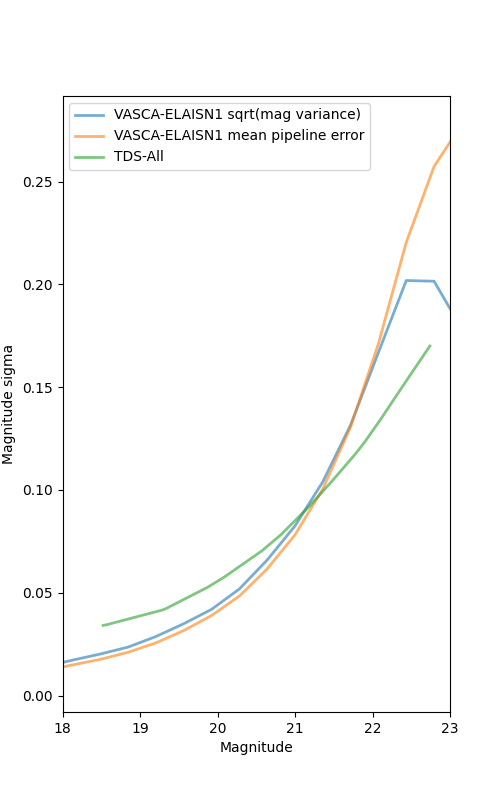

In [38]:
#Source selection
sel_cpval = rg.tt_sources["flux_cpval"]>0.01
#rg.tt_fields.add_index("field_id")
#fd = rg.tt_fields.loc["field_id", "GNU2605053246158405632"]
#sel_field = rg.tt_sources["rg_fd_id"]==fd["rg_fd_id"]
sel_ndet = rg.tt_sources["nr_det"]>10
sel_all = sel_cpval*sel_ndet#*sel_field

mag_var_hist, var_bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=20, density=False, weights = np.sqrt(rg.tt_sources["mag_var"][sel_all]))
mag_err_hist, var_bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=20, density=False, weights = rg.tt_sources["mag_err_mean"][sel_all])
mag_var_entries, bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=var_bins, density=False)
var_bins_mean = (var_bins[:-1]+var_bins[1:])/2.

#Get TDS Fig 3 data
tt_tds= Table.read("./TDS-ApJ_766_60/GezariApJ2013_TDS_Fig3.csv")

#Plot
fig_mag_var = plt.figure(figsize=(5, 8))
plt.plot(var_bins_mean , mag_var_hist/mag_var_entries ,lw=2, alpha=0.6, label="VASCA-ELAISN1 sqrt(mag variance)")
plt.plot(var_bins_mean , mag_err_hist/mag_var_entries ,lw=2, alpha=0.6, label="VASCA-ELAISN1 mean pipeline error")
#plt.plot(tt_tds["mag"] , tt_tds["MOS23"] ,lw=2, alpha=0.6, label="TDS-MOS23")
plt.plot(tt_tds["mag"] , tt_tds["TDS"] ,lw=2, alpha=0.6, label="TDS-All")
plt.xlabel("Magnitude")
plt.ylabel("Magnitude sigma")
plt.legend()
plt.xlim([18, 23])
fig_mag_var.savefig("./vasca_pipeline/"+region_name+"/vasca_"+region_name+"_mag_err.png")
#plt.semilogy()

In [39]:
### Angular resolution comparison distribution to errors

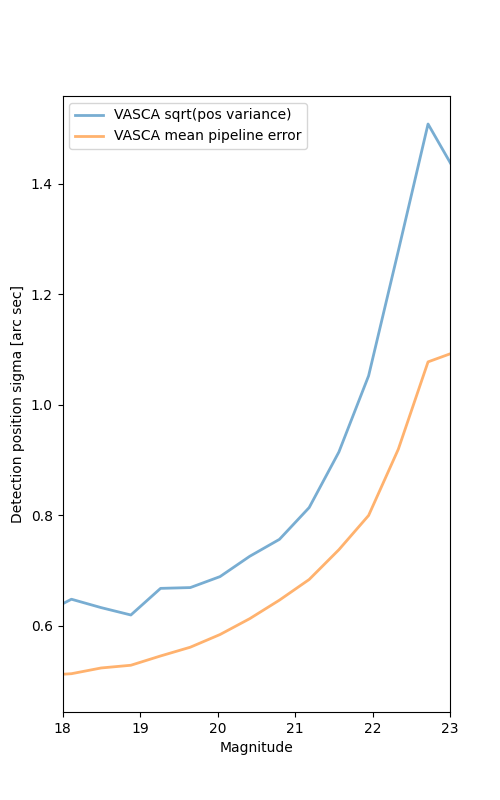

In [40]:
#Source selection
sel_cpval = rg.tt_sources["flux_cpval"]>0.01
#sel_field = rg.tt_sources["rg_fd_id"]==fd["rg_fd_id"]
sel_ndet = rg.tt_sources["nr_det"]>10
sel_all = np.ones(len(rg.tt_sources),dtype=bool) # sel_cpval*sel_ndet*sel_field

pos_var_hist, var_bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=20, density=False, weights = np.sqrt(rg.tt_sources["pos_var"][sel_all]))
pos_err_hist, var_bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=20, density=False, weights = rg.tt_sources["pos_err_mean"][sel_all])
pos_var_entries, bins = np.histogram(rg.tt_sources["mag_mean"][sel_all], bins=var_bins, density=False)
pos_bins_mean = (var_bins[:-1]+var_bins[1:])/2.

#Plot
fig_pos_var = plt.figure(figsize=(5, 8))
plt.plot(pos_bins_mean , 3600*pos_var_hist/pos_var_entries ,lw=2, alpha=0.6, label="VASCA sqrt(pos variance)")
plt.plot(pos_bins_mean , 3600*pos_err_hist/pos_var_entries ,lw=2, alpha=0.6, label="VASCA mean pipeline error")
plt.xlabel("Magnitude")
plt.ylabel("Detection position sigma [arc sec]")
plt.legend()
plt.xlim([18, 23])
fig_pos_var.savefig("./vasca_pipeline/"+region_name+"/vasca_"+region_name+"_pos_err.png")
#plt.semilogy()

In [41]:
### Comparison to TDS catalog

In [45]:
#Select vasca sources, 5 sigma 0.000000573303, 4 sigma 0.00006334, 3 sigma = 0.002699796
sel_vasca = (rg.tt_sources["flux_cpval"]<0.002699796) * (rg.tt_sources["flux_cpval"]>-0.5)
#sel_vasca = rg.tt_sources["mag_dmax_sig"]>5
tt_vasca = rg.tt_sources[sel_vasca]

#Read TDS
tt_tds = Table.read("./TDS-ApJ_766_60/table4.fit", hdu="J_ApJ_766_60_table4")
display(tt_tds)

#Match VASCA-TDS
pos_tds = SkyCoord(ra=tt_tds["RAJ2000"], dec=tt_tds["DEJ2000"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="icrs")
idx_tds, dist_tds, _ = match_coordinates_sky(pos_vasca, pos_tds)
dist_lim = (5 * uu.arcsec).to("deg")
sel_dist = dist_tds <= dist_lim

#Print out
print("Total number of VASCA-TDS source matches:",sel_dist.sum())
print("TDS sources total:",len(tt_tds),", VASCA sources total:",len(tt_vasca))

recno,ID,RAJ2000,DEJ2000,l_mlow,mlow,l_Dmmax,Dmmax,l_sigint,sigint,l_Sd,Sd,l_Sy,Sy,LC,Mph,rmag,OT,z,X,Class
,,deg,deg,,mag,,mag,,mag,,mag,,mag,,,mag,,,,
int32,bytes16,float64,float64,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,bytes3,float32,bytes3,float32,bytes1,bytes12
1,GROTH_MOS01-21,216.1622,54.0911,,22.54,,4.60,,1.04,,0.80,,1.13,V,pt,14.92,Mdw,--,,Mdw
2,VVDS22H_MOS05-05,333.8326,-0.5491,,21.14,,4.47,,0.99,,0.90,,0.74,F,pt,21.24,QSO,--,,CV
3,ELAISN1_MOS15-02,242.0397,54.3586,>,22.89,>,4.03,,1.37,,0.84,,2.93,V,pt,22.51,QSO,--,,CV
4,ELAISN1_MOS15-09,242.3685,53.6738,>,23.03,>,4.02,,1.23,,0.01,,2.15,F,ext,21.05,,--,,Galaxy Trans
5,GROTH_MOS07-09,212.5024,52.4153,>,23.10,>,3.61,,3.51,,0.09,,0.69,F,pt,17.45,Mdw,--,,Mdw
6,CDFS_MOS02-20,53.1682,-26.3564,>,23.06,>,3.60,,0.73,,0.95,,0.78,,,15.72,Mdw,--,,Mdw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,COSMOS_MOS21-12,150.5294,3.0580,,18.07,,0.26,,0.07,<,0.00,,0.13,V,ext,13.93,,0.023,,AGN


Total number of VASCA-TDS source matches: 642
TDS sources total: 1078 , VASCA sources total: 4131
